In [422]:
import pandas as pd
import numpy as np

In [849]:
training_cards = []

In [880]:
def sample_uniform(n, maxVal):
    return np.random.choice(np.arange(maxVal), n)

def featurize(arr):
    histogram = np.histogram(arr, bins=np.arange(0,10,1))
    return histogram[0].astype(float)

In [881]:
test = []
for _ in range(15):
    t = sample_uniform(100, 10)
    #t = np.random.uniform(size=100)
    # = np.random.zipf(1.001, 100)
    test.append((t, featurize(t)))

In [882]:
def cardinality(a1, a2):
    """Takes 2 numpy arrays and returns the cardinality of the join"""
    df1 = pd.DataFrame(a1, columns=['a'])
    df2 = pd.DataFrame(a2, columns=['a'])
    joined = pd.merge(df1, df2, on='a', how='inner')
    return len(joined.index)

## Graph Nets

In [884]:
import collections
import time

#from graph_nets import utils_np
# from graph_nets import utils_tf
# from graph_nets.demos import models
import graph_nets.utils_np as utils_np
import graph_nets.utils_tf as utils_tf
import graph_nets.demos.models as models
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import importlib

In [885]:
models = importlib.reload(models)
models.NUM_LAYERS

3

In [886]:
def create_graph_dicts(num_examples, testing=False):
    input_graphs = []
    cardinalities = []
    if(testing):
        assert(num_examples == 105)
        for combo in list(itertools.combinations(range(15), 2)):
            i1 = combo[0]
            i2 = combo[1]
            data1 = test[i1][0]
            data2 = test[i2][0]
            features1 = test[i1][1]
            features2 = test[i2][1]
            card = cardinality(data1, data2)
            input_graphs.append({"nodes": np.array([features1, features2]), "receivers": [0, 1], "senders": [1, 0]})
            cardinalities.append(card)
    else:
        for _ in range(num_examples):
            f = True
            #while(f):
            data1 = sample_uniform(100, 10)
            data2 = sample_uniform(100, 10)
            #data1, data2 = sample_correlated()
            features1 = featurize(data1)
            features2 = featurize(data2)
            card = cardinality(data1, data2)
                #if(card <= 950): f = False
            input_graphs.append({"nodes": np.array([features1, features2]), "receivers": [0, 1], "senders": [1, 0]})
            cardinalities.append(card)
            training_cards.append(card)
    return input_graphs, cardinalities

In [887]:
def create_target_dicts(batch_size, input_dicts, estimated_cards):
    target_dicts = []
    for i in range(batch_size):
        cardinality = estimated_cards[i]
        edges = [[cardinality], [cardinality]]
        #a = np.zeros(26)
        #a[cardinality] = 1
        #edges = np.array([a, a])
        target_dict = input_dicts[i].copy()
        #target_dict['nodes'] = edges
        target_dict['edges'] = edges
        target_dicts.append(target_dict)
    return target_dicts

In [888]:
def create_data_ops(batch_size, testing=False):
    inputs_op, estimated_cards = create_graph_dicts(batch_size, testing)
    
    targets_op = create_target_dicts(batch_size, inputs_op, estimated_cards)
    
    return inputs_op, targets_op

In [889]:
def create_placeholders(batch_size):
    """Creates placeholders for the model training and evaluation"""
    input_graphs, target_graphs = create_data_ops(batch_size)
    input_ph = utils_tf.placeholders_from_data_dicts(input_graphs, force_dynamic_num_graphs=True)
    target_ph = utils_tf.placeholders_from_data_dicts(target_graphs, force_dynamic_num_graphs=True)
    return input_ph, target_ph

In [890]:
def create_feed_dict(batch_size, input_ph, target_ph, testing=False):
    inputs_graphs, target_graphs = create_data_ops(batch_size, testing)
    input_graphs = utils_np.data_dicts_to_graphs_tuple(inputs_graphs)
    target_graphs = utils_np.data_dicts_to_graphs_tuple(target_graphs)

    feed_dict_input = utils_tf.get_feed_dict(input_ph, input_graphs)
    feed_dict_target = utils_tf.get_feed_dict(target_ph, target_graphs)
    feed_dict = {**feed_dict_input, **feed_dict_target}
    return feed_dict

In [891]:
def make_all_runnable_in_session(*args):
    return [utils_tf.make_runnable_in_session(a) for a in args]

In [892]:
tf.reset_default_graph()
input_ph, target_ph = create_placeholders(1)
input_out, target_out = make_all_runnable_in_session(input_ph, target_ph)

In [893]:
with tf.Session() as sess:
    for _ in range(3):
        feed_dict = create_feed_dict(1, input_ph, target_ph)
        inputs_graphs, targets_graphs = sess.run([input_out, target_out], feed_dict=feed_dict)
        print("Input Graphs: ",inputs_graphs)
        print("Target Graphs: ", targets_graphs)

Input Graphs:  GraphsTuple(nodes=array([[ 0.,  7.,  1.,  3.,  3.,  2.,  4.,  6.,  1.,  5.,  0.,  5.,  2.,
         4.,  0.,  7.,  3.,  3.,  7.,  2.,  4.,  4.,  8.,  3.,  0.,  3.,
         1.,  8.,  1.,  6.,  5.,  4.,  1.,  2.,  0.,  2.,  9.,  2.,  3.,
         8.,  2.,  4.,  1.,  9.,  1.,  9.,  6.,  0.,  2.,  1.,  0.,  7.,
         2.,  0.,  8.,  4.,  3.,  2.,  6.,  8.,  7.,  0.,  8.,  7.,  5.,
         1.,  8.,  1.,  1.,  8.,  4.,  1.,  8.,  0.,  4.,  4.,  2.,  9.,
         9.,  8.,  8.,  3.,  3.,  6.,  9.,  0.,  2.,  4.,  1.,  5.,  1.,
         9.,  7.,  9.,  3.,  8.,  2.,  1.,  5.,  7.],
       [ 3.,  2.,  4.,  8.,  1.,  4.,  7.,  5.,  6.,  7.,  8.,  0.,  4.,
         1.,  3.,  4.,  4.,  4.,  0.,  4.,  3.,  0.,  0.,  9.,  2.,  2.,
         0.,  6.,  7.,  0.,  9.,  1.,  6.,  1.,  1.,  3.,  8.,  6.,  5.,
         6.,  1.,  5.,  4.,  9.,  9.,  5.,  7.,  3.,  4.,  2.,  1.,  7.,
         6.,  1.,  4.,  5.,  2.,  3.,  4.,  2.,  1.,  2.,  1.,  0.,  8.,
         4.,  3.,  3.,  9.,  0.,  2.,

In [894]:
def compute_accuracy(target, output):
    """Computes symmetric mean absolute percentage error and solved accuracy of the final graph. Returns fraction of correctly solved cardinalities
    
        Target is the target graph
        Output is the output graph"""
    target_dicts = utils_np.graphs_tuple_to_data_dicts(target)
    output_dicts = utils_np.graphs_tuple_to_data_dicts(output)
    percent_difference = []
    correctly_solved = []
    for td, od in zip(target_dicts, output_dicts):
        is_equal = np.equal(od['edges'], td['edges'])
        numerator = np.absolute(od['edges']-td['edges'])
        denom = np.absolute(od['edges']) + np.absolute(td['edges'])
        denom = np.where(is_equal, [1, 1], denom)
        pd = np.mean(np.divide(numerator, denom))
        percent_difference.append(pd)
        correctly_solved.append(np.equal(np.round(np.mean(od['edges'])), np.mean(td['edges'])))
    correct = np.mean(correctly_solved)
    pd = np.mean(percent_difference)
    return pd, correct

def compute_classification_accuracy(target, output):
    return 1, 1

In [895]:
def create_loss_ops(target_op, output_ops):
    if not isinstance(output_ops, collections.Sequence):
        output_ops = [output_ops]
    
    loss_ops = [
        tf.losses.mean_squared_error(target_op.edges, output_op.edges) for output_op in output_ops
    ]
    
    return loss_ops

In [896]:
def create_l1_loss_ops(target_op, output_ops):
    if not isinstance(output_ops, collections.Sequence):
        output_ops = [output_ops]
    
    loss_ops = [
        tf.losses.absolute_difference(target_op.edges, output_op.edges) for output_op in output_ops
    ]
    
    return loss_ops

In [897]:
def create_softmax_loss_ops(target_op, output_ops):
    if not isinstance(output_ops, collections.Sequence):
        output_ops = [output_ops]
    
    loss_ops = [
        tf.losses.softmax_cross_entropy(target_op.edges, output_op.edges)
        for output_op in output_ops
    ]
    
    return loss_ops

In [898]:
tf.reset_default_graph()

# seed = 3
# rand = np.random.RandomState(seed=seed)

In [899]:
num_processing_steps_tr = 10
num_processing_steps_ge = 10

num_training_iterations = 3000
batch_size_tr = 32
batch_size_ge = 105

In [900]:
input_ph, target_ph = create_placeholders(batch_size_tr)
input_ph_dummy = utils_tf.set_zero_edge_features(input_ph, 1, dtype=tf.float64)
input_ph_dummy = utils_tf.set_zero_global_features(input_ph_dummy, 1, dtype=tf.float64)

model = models.EncodeProcessDecode(edge_output_size=1, node_output_size=None)
output_ops_tr = model(input_ph_dummy, num_processing_steps_tr)
output_ops_ge = model(input_ph_dummy, num_processing_steps_ge)

In [901]:
# Loss.
loss_ops_tr = create_l1_loss_ops(target_ph, output_ops_tr)
#loss_ops_tr = create_softmax_loss_ops(target_ph, output_ops_tr)
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr  # loss_ops_tr
#loss_ops_ge = create_softmax_loss_ops(target_ph, output_ops_ge)
loss_ops_ge = create_l1_loss_ops(target_ph, output_ops_tr)
loss_op_ge = loss_ops_ge[-1]

# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

/home/amogkamsetty/anaconda3/envs/env_full_py3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [902]:
input_out, target_out = make_all_runnable_in_session(input_ph, target_ph)

In [903]:
# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
  sess.close()
except NameError:
  pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []

In [904]:
# How much time between logging and printing the current results.
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Ctr (training fraction nodes/edges labeled correctly), "
      "Str (training fraction examples solved correctly), "
      "Cge (test/generalization fraction nodes/edges labeled correctly), "
      "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  feed_dict = create_feed_dict(batch_size_tr, input_ph, target_ph, testing=False)
  train_values = sess.run({
      "step": step_op,
      "inputs": input_out,
      "targets": target_out,
      "loss": loss_op_tr,
      "outputs": output_ops_tr
  }, feed_dict = feed_dict)
  #print("Input Graphs: ",train_values["inputs"])
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    feed_dict = create_feed_dict(
        batch_size_ge, input_ph, target_ph, testing=True)
    #print(feed_dict)
    test_values = sess.run({
        "targets": target_out,
        "loss": loss_op_ge,
        "outputs": output_ops_ge,
    }, feed_dict=feed_dict)
    #print(train_values["targets"])
    #print(train_values["outputs"])
    #pd_tr, correct_tr = compute_accuracy(train_values["targets"],
     #                                        train_values["outputs"][-1])
    #pd_ge, correct_ge = compute_accuracy(test_values["targets"],
     #                                        test_values["outputs"][-1])
    elapsed = time.time() - start_time
    losses_tr.append(train_values["loss"])
    #corrects_tr.append(pd_tr)
    #solveds_tr.append(correct_tr)
    losses_ge.append(test_values["loss"])
    #solveds_ge.append(correct_ge)
    #corrects_ge.append(pd_ge)
    logged_iterations.append(iteration)
    print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, Pdtr {:.4f}, "
          "Ctr {:.4f}, Pdge {:.4f}, Cge {:.4f}".format(
              iteration, elapsed, train_values["loss"], test_values["loss"], 0, 0, 0, 0))
              #pd_tr, correct_tr, pd_ge, correct_ge))

# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Ctr (training fraction nodes/edges labeled correctly), Str (training fraction examples solved correctly), Cge (test/generalization fraction nodes/edges labeled correctly), Sge (test/generalization fraction examples solved correctly)
# 00079, T 22.3, Ltr 1001.6959, Lge 992.9273, Pdtr 0.0000, Ctr 0.0000, Pdge 0.0000, Cge 0.0000
# 00288, T 40.5, Ltr 975.0672, Lge 975.8417, Pdtr 0.0000, Ctr 0.0000, Pdge 0.0000, Cge 0.0000
# 00508, T 60.5, Ltr 951.2288, Lge 944.3151, Pdtr 0.0000, Ctr 0.0000, Pdge 0.0000, Cge 0.0000
# 00730, T 80.4, Ltr 907.7233, Lge 898.4662, Pdtr 0.0000, Ctr 0.0000, Pdge 0.0000, Cge 0.0000
# 00948, T 100.5, Ltr 839.7448, Lge 840.2728, Pdtr 0.0000, Ctr 0.0000, Pdge 0.0000, Cge 0.0000
# 01166, T 120.5, Ltr 775.0416, Lge 769.7019, Pdtr 0.0000, Ctr 0.0000, Pdge 0.0000, Cge 0.0000
# 01393, T 140.6, Ltr 687.0396, Lge 683.8022, Pdtr 0.0000, Ctr 0.0000, Pdge 0.0000, Cge 0.0000
# 01609, 

ValueError: x and y must have same first dimension, but have shapes (13,) and (0,)

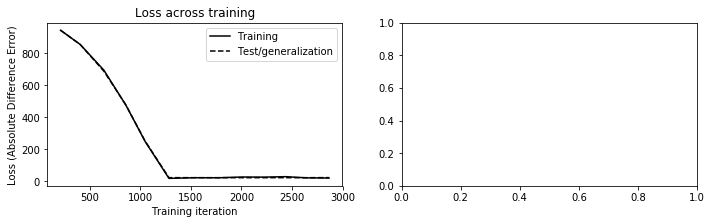

In [848]:
# This cell visualizes the results of training. You can visualize the
# intermediate results by interrupting execution of the cell above, and running
# this cell. You can then resume training by simply executing the above cell
# again.

# Plot results curves.
fig = plt.figure(11, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Loss.
y_tr = losses_tr
y_ge = losses_ge
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Loss across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss (Absolute Difference Error)")
ax.legend()
# Correct.
y_tr = corrects_tr
y_ge = corrects_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("SMAPE across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("SMAPE")
# Solved.
y_tr = solveds_tr
y_ge = solveds_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction solved across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction examples solved")

In [ ]:
l = []
for i in test:
    l.extend(i[0])
plt.hist(l)

In [ ]:
cardinalities = []
for combo in list(itertools.combinations(range(15), 2)):
    i1 = combo[0]
    i2 = combo[1]
    data1 = test[i1][0]
    data2 = test[i2][0]
    card = cardinality(data1, data2)
    cardinalities.append(card)
plt.hist(cardinalities, bins=19)

In [912]:
train_values['outputs'][0].edges

array([[ 1000.65538291],
       [ 1000.65615639],
       [ 1000.65557042],
       [ 1000.65907184],
       [ 1000.65879409],
       [ 1000.65913689],
       [ 1000.65756173],
       [ 1000.65825223],
       [ 1000.65799393],
       [ 1000.65439178],
       [ 1000.65489675],
       [ 1000.65766688],
       [ 1000.65749853],
       [ 1000.65733925],
       [ 1000.65899643],
       [ 1000.65924845],
       [ 1000.65787156],
       [ 1000.6558729 ],
       [ 1000.65803025],
       [ 1000.65439906],
       [ 1000.65879684],
       [ 1000.65698113],
       [ 1000.65795469],
       [ 1000.65699034],
       [ 1000.65516335],
       [ 1000.65913494],
       [ 1000.65792141],
       [ 1000.65678222],
       [ 1000.65139241],
       [ 1000.6540059 ],
       [ 1000.6552805 ],
       [ 1000.65905406],
       [ 1000.65861842],
       [ 1000.65680324],
       [ 1000.65815887],
       [ 1000.65744746],
       [ 1000.65861963],
       [ 1000.65690552],
       [ 1000.65862462],
       [ 1000.65869732],


In [697]:
train_values['targets']

GraphsTuple(nodes=array([[ 14.,  10.,   6.,  14.,   6.,  10.,  14.,   7.,  19.],
       [  9.,   9.,  14.,   8.,   9.,  11.,  13.,  12.,  15.],
       [ 14.,  10.,   7.,   9.,  11.,   8.,   9.,   8.,  24.],
       [ 10.,  11.,   7.,   8.,  17.,  11.,  11.,   9.,  16.],
       [  6.,  11.,  14.,   8.,  10.,  12.,   9.,   6.,  24.],
       [  9.,   7.,  10.,  13.,  13.,  11.,   9.,   9.,  19.],
       [ 13.,  13.,   6.,  12.,  10.,   8.,   7.,  12.,  19.],
       [  6.,  13.,  11.,  10.,   7.,   8.,  12.,  11.,  22.],
       [  7.,  12.,   9.,   6.,   6.,  18.,  11.,   7.,  24.],
       [  9.,  11.,  10.,  19.,   3.,   8.,   7.,  13.,  20.],
       [ 11.,  12.,  11.,   7.,  12.,   8.,  10.,  12.,  17.],
       [  9.,   6.,  13.,   8.,  11.,   9.,   8.,  13.,  23.],
       [  7.,  13.,  15.,   6.,   9.,   6.,   7.,  15.,  22.],
       [ 16.,  10.,  11.,   9.,  12.,   8.,  16.,   6.,  12.],
       [ 15.,   8.,  11.,  12.,  10.,   6.,   7.,  10.,  21.],
       [  7.,   9.,   6.,  12.,   7.,

(array([  8.00000000e+00,   1.04000000e+02,   9.81000000e+02,
          5.78400000e+03,   1.81770000e+04,   1.89230000e+04,
          5.80800000e+03,   1.00000000e+03,   1.17000000e+02,
          1.40000000e+01]),
 array([  843. ,   874.4,   905.8,   937.2,   968.6,  1000. ,  1031.4,
         1062.8,  1094.2,  1125.6,  1157. ]),
 <a list of 10 Patch objects>)

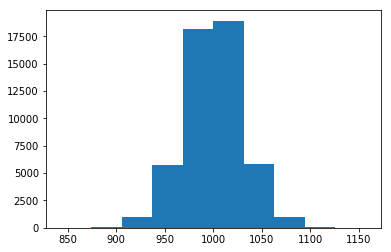

In [698]:
plt.hist(training_cards)

In [699]:
np.mean(training_cards)

1000.0448974781993